# Stock prices

_UNDER CONSTRUCTION_

- Sample selection, survivorship bias
- Stock delistings and post-delisting returns
- Stock distributions, split-adjustments, dividends and stock returns


In [1]:

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database.sql import SQL
from finds.database.redisdb import RedisDB
from finds.busday import BusDay
from finds.structured.crsp import CRSP
from finds.structured.finder import Finder
from finds.plots import plot_date, plot_bar, set_xtickbins
from finds.misc.show import Show
from secret import credentials, paths, CRSP_DATE
show = Show(ndigits=4, latex=None)
VERBOSE = 0
# %matplotlib qt

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, monthly=True, verbose=VERBOSE)
imgdir = paths['images']

## Sample selection

### Fama-French universe
Following Fama and French (1992), the CRSP universe is trimmed to only include US-domiciled, exchange-listed stocks:
 - Market cap must be available on date, with prc > 0.0
 - shrcd in [10, 11], exchcd in [1, 2, 3]

The universe is often divided into 10 deciles (with the 10th decile comprising stocks with smallest market capitalizaion) with breakpoints determined only from those stocks listed on the NYSE.  The plots below show the market cap breakpoints of and the number of stocks in each decile by year.

In [3]:
# retrieve universe of stocks annually from 1981
start = bd.endyr(19811231)
rebals = bd.date_range(start, CRSP_DATE, freq=12)
univs = {rebal: crsp.get_universe(date=rebal) for rebal in rebals}

In [4]:
# find market cap break points of and number of stocks in each size decile by year
cap, num = dict(), dict()
for date, univ in univs.items():
    cap[str(date//10000)] = {decile: min(univ.loc[univ['decile']==decile, 'cap'])
                             for decile in range(9, 0, -1)}
    num[str(date//10000)] = {decile: sum(univ['decile']==decile)
                            for decile in range(10, 0, -1)}
cap = DataFrame.from_dict(cap, orient='index')
num = DataFrame.from_dict(num, orient='index')

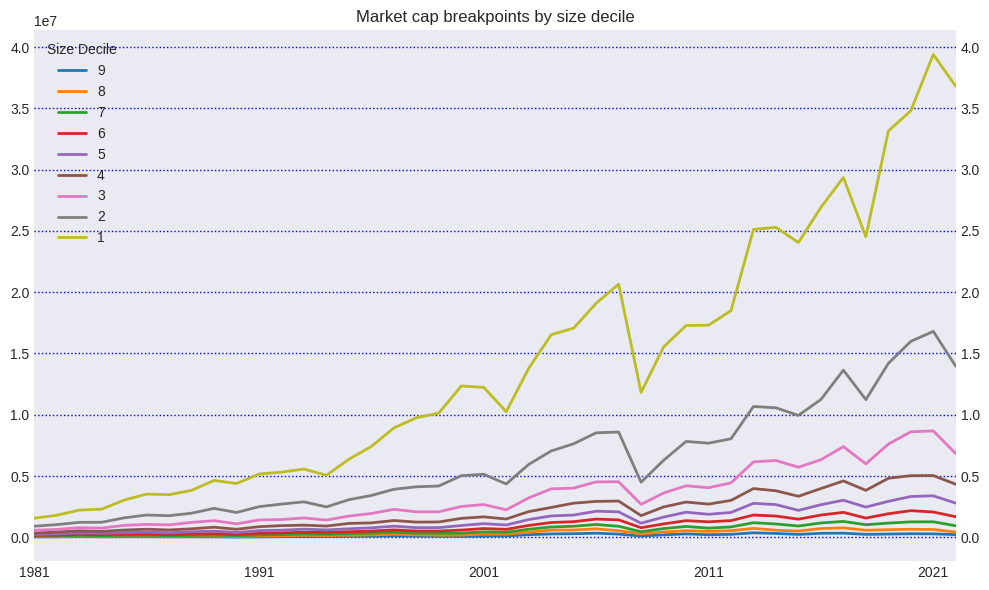

In [5]:
# plot market cap break points
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Market cap breakpoints by size decile')
cap.plot.line(ax=ax, lw=2)
ax.tick_params(labeltop=False, labelright=True)
ax.grid(visible=True, axis='y', color='b', ls=':', lw=1)         # show y-axis grids
set_xtickbins(ax=ax, nbins=len(cap)//10)
plt.legend(title='Size Decile', loc='upper left')
plt.tight_layout()

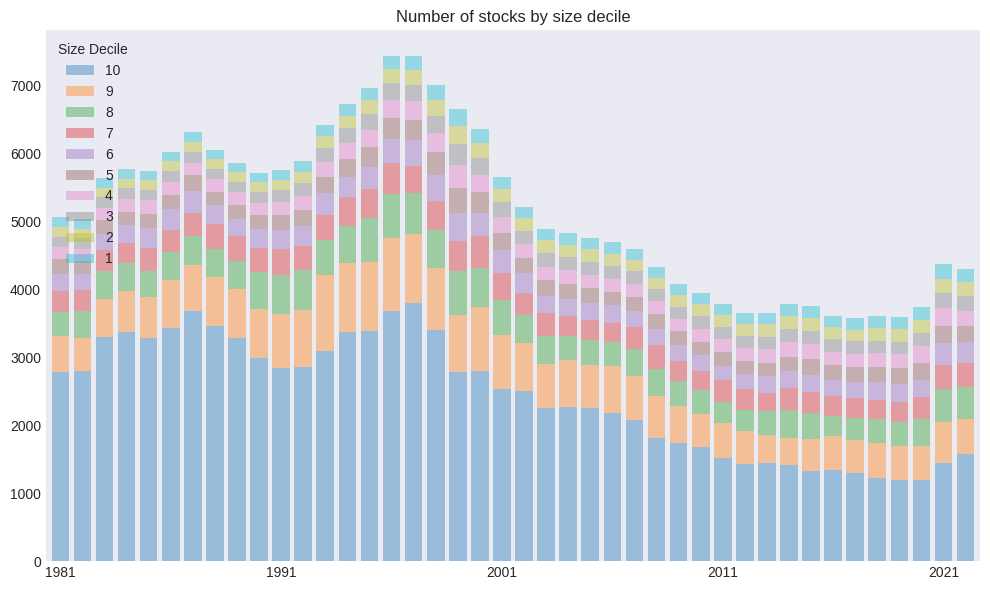

In [6]:
# plot number of stocks in each size decile
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Number of stocks by size decile')
num.plot.bar(stacked=True, ax=ax, width=.8, alpha=0.4)
set_xtickbins(ax=ax, nbins=len(cap)//10)
plt.legend(title='Size Decile', loc='upper left')
plt.tight_layout()

### Survivorship bias
Sample bias occurs when some members of a population are systematically more likely to be selected in a sample than others. Survivorship bias is a particular form where only existing or “surviving” stocks are considered when measuring the performance of a portfolio. Stocks that have ceased to exist are not included, and therefore the portfolio's return profile could be overestimated.

In [7]:
# compute cap-weighted returns through latest CRSP_DATE of survivors and all
diff, cap, num = dict(), dict(), dict()
for rebal in rebals[:-1]:
    univ = univs[rebal]
    nyears = np.round((CRSP_DATE - rebal) / 10000)            # years elapsed
    df = crsp.get_ret(bd.offset(rebal, +1), CRSP_DATE, delist=True)\
             .reindex(univ.index)\
             .fillna(0)                                       # include delist returns
    permnos = univ.index.intersection(univs[CRSP_DATE].index) # permnos of survivors
    total = ((1+df).dot(univ['cap']) / univ['cap'].sum())**(1/nyears)
    ret = ((1+df[permnos]).dot(univ.loc[permnos, 'cap'])      # annualized return
           / univ.loc[permnos, 'cap'].sum())**(1/nyears)
    diff[str(rebal)] = ret - total
    cap[str(rebal)] = univ.loc[permnos, 'cap'].sum() / univ['cap'].sum()
    num[str(rebal)] = len(permnos) / len(univ.index)

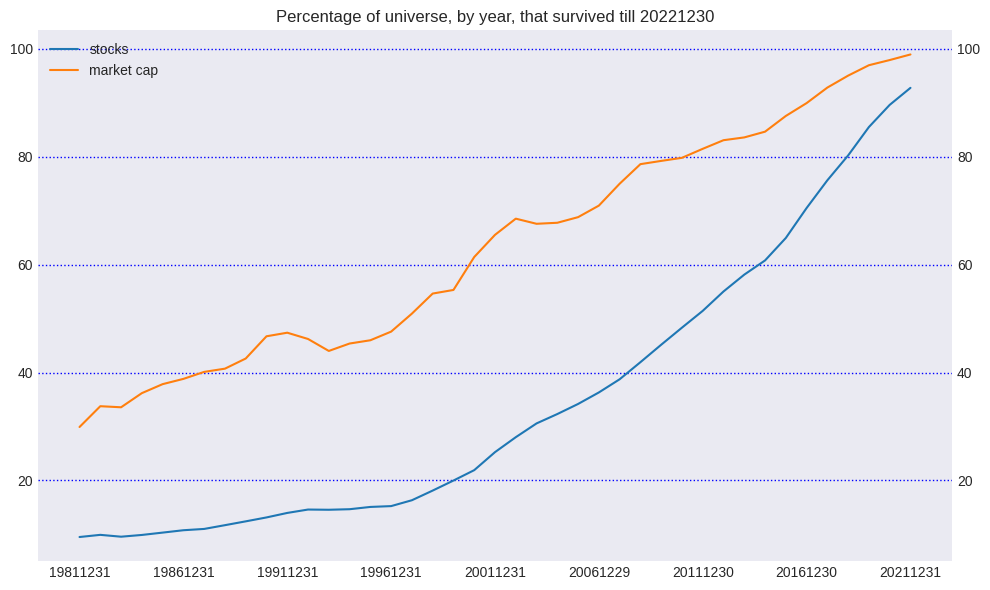

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Percentage of universe, by year, that survived till {CRSP_DATE}")
(DataFrame.from_dict({'stocks': num,
                      'market cap': cap},
                     orient='columns') * 100).plot.line(ax=ax)
ax.grid(visible=True, axis='y', color='b', ls=':', lw=1)         # show y-axis grids
ax.tick_params(labeltop=False, labelright=True)
plt.tight_layout()

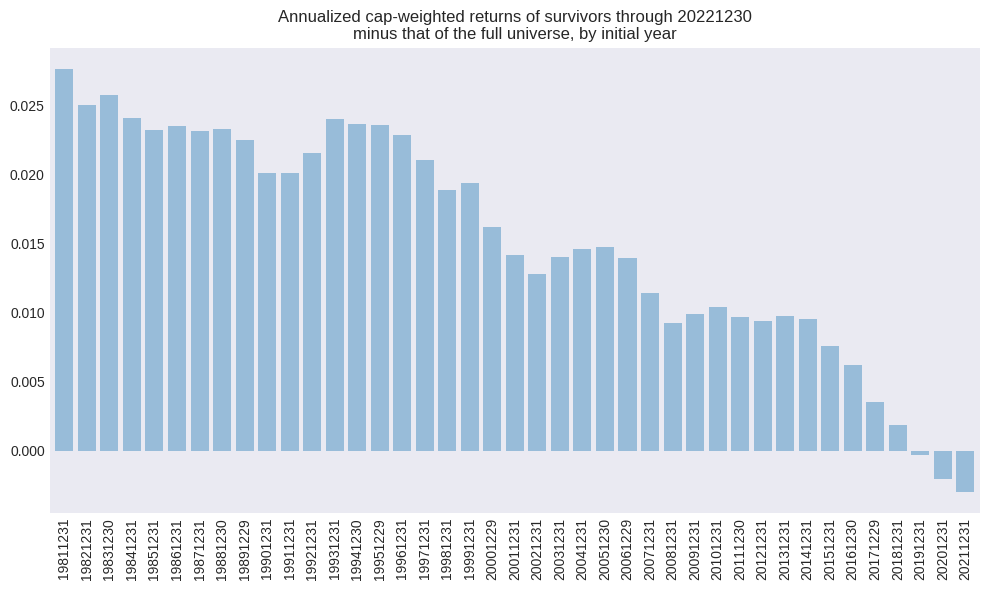

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Annualized cap-weighted returns of survivors through {CRSP_DATE}\n"
             f"minus that of the full universe, by initial year")
Series(diff).plot.bar(ax=ax, width=.8, alpha=0.4)
plt.tight_layout()

## Stock delistings

Following Bali, Engle, and Murray (2016) and Shumway (1997): we can construct returns adjusted for delistings, which result when a company is acquired, ceases operations, or fails to meet exchange listing requirements. 

For CRSP Monthly, the adjustment reflects the partial month returns of investors who bought the stock in the month before the delisting. For certain delisting codes ([500, 520, 551..574, 580, 584]) where the delisting return is missing, an adjusted return of -30% is assumed to reflect the average recovery amount after delisting.

For CRSP Daily, a quick and close approximation of $(1+$ DLRET $)~(1+$ RET $)-1$ on the last trading date can be applied.


In [10]:
avg, mab, num, frac, diff = dict(), dict(), dict(), dict(), dict()
for rebal, end in zip(rebals[:-1], rebals[1:]):
    univ = univs[rebal]
    ret = crsp.get_ret(bd.offset(rebal, +1), end, delist=False)\
              .reindex(univ.index)\
              .fillna(0)
    dlret = crsp.get_dlret(bd.offset(rebal, +1), end).reindex(univ.index)
    num[str(rebal)] = (~dlret.isna()).sum()
    frac[str(rebal)] = num[str(rebal)] / len(ret)
    diff[str(rebal)] = (1+dlret[~dlret.isna().values]).to_list()
    avg[str(rebal)] = dlret[~dlret.isna().values].mean()
    mab[str(rebal)] = dlret[~dlret.isna().values].abs().mean()

__Box plot of the distribution of delisting returns__


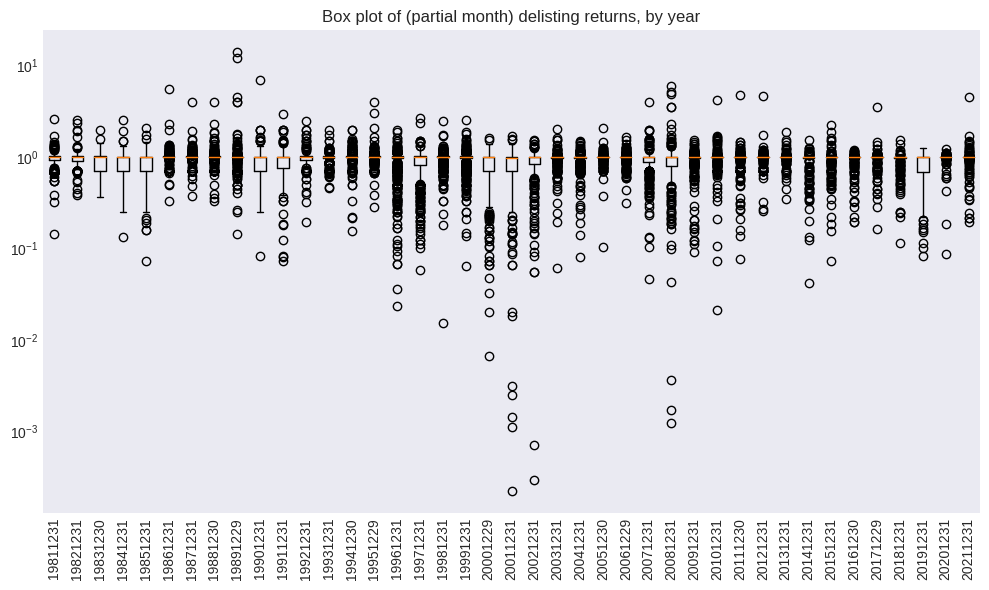

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Box plot of (partial month) delisting returns, by year")
ax.boxplot(list(diff.values()), labels=list(diff.keys()))
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=90) # set tick rotation
plt.tight_layout()

__Plot of the mean, and average absolute delisting returns__

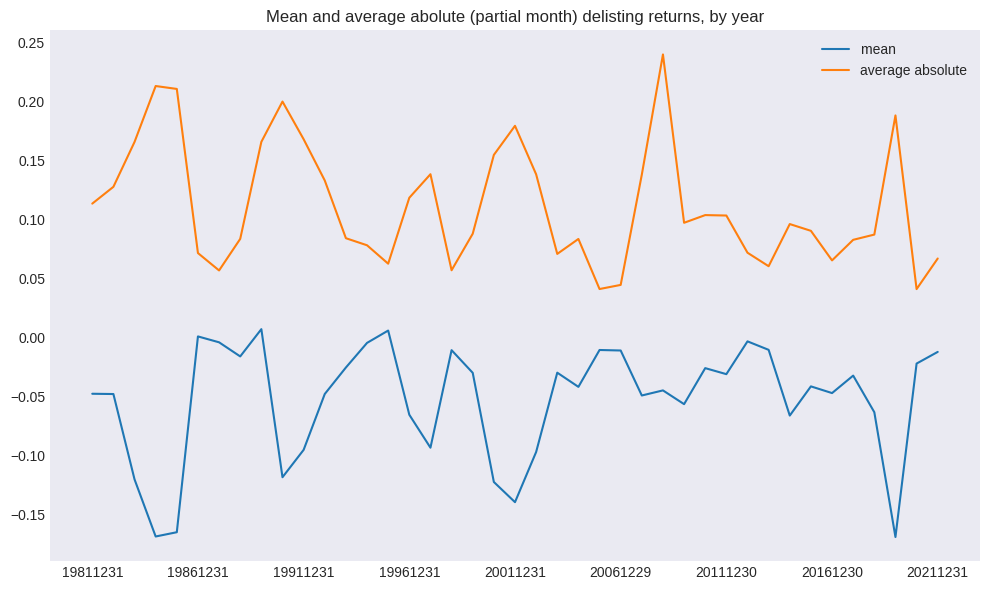

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Mean and average abolute (partial month) delisting returns, by year")
Series(avg).rename('mean').plot(ax=ax)
Series(mab).rename('average absolute').plot(ax=ax)
plt.legend()
plt.tight_layout()

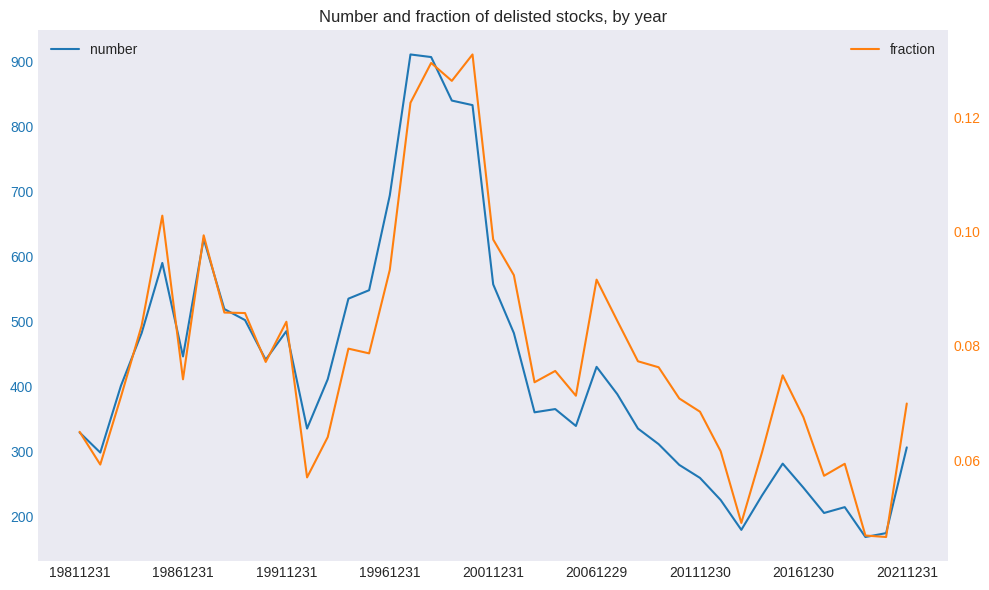

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Number and fraction of delisted stocks, by year")
Series(num).rename('number').plot(ax=ax, color="C0")
ax.legend(loc='upper left')
ax.tick_params(axis='y', colors='C0')
bx = ax.twinx()
Series(frac).rename('fraction').plot(ax=bx, color="C1")
bx.tick_params(axis='y', colors='C1')
bx.legend(loc='upper right')
plt.tight_layout()

## Stock distributions and returns

In [14]:
ticker = 'AAPL'
find = Finder(sql)        # to search identifier lookup tables
names = find(ticker)      # locate names records by ticker
show(names)

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,19821101,APPLE COMPUTER INC,03783310,,AAPL,14593,20040609,11,3,3573,AAPL,0,Q,A,R,7
1,20040610,APPLE COMPUTER INC,03783310,,AAPL,14593,20070110,11,3,3573,AAPL,334111,Q,A,R,7
2,20070111,APPLE INC,03783310,,AAPL,14593,20171227,11,3,3571,AAPL,334111,Q,A,R,7
3,20171228,APPLE INC,03783310,,AAPL,14593,20221230,11,3,3571,AAPL,334220,Q,A,R,7


In [15]:
# Get raw price and distributions history from CRSP Daily
where = f" where permno = {names['permno'].iloc[-1]}"
dist = sql.read_dataframe(f"select * from {crsp['dist'].key} {where}")
crsp_df = sql.read_dataframe(f"select * from {crsp['daily'].key} {where}")\
             .set_index('date', inplace=False)
crsp_df
crsp_columns = crsp_df.columns

In [16]:
# Retrieve price history from yahoo finance
from yahoo import get_price
yahoo_df = get_price(ticker, start_date='19800101', verbose=VERBOSE)
yahoo_df.rename_axis(ticker)
yahoo_columns = yahoo_df.columns

cookies True crumb None
https://finance.yahoo.com/quote/^GSPC


In [17]:
# Merge yahoo and CRSP by date
df = crsp_df[['prc', 'ret', 'retx']]\
    .join(dist[dist['facpr'] != 0.0].set_index('exdt')['facpr'])\
    .join(dist[dist['divamt'] != 0.0].set_index('exdt')['divamt'])\
    .join(yahoo_df[['close', 'adjClose']], how='inner')


__Price Appreciation__

The Factor to Adjust Price (_facpr_) can be used to adjust prices after distributions (usually stock dividends and splits) so that stock prices before and after the distribution are comparable.  The compounded factor between two dates can be divided into raw stock prices to derive comparable split-adjusted prices.


In [18]:
# Cumulate factor to adjust pre-split prices prior to ex-date
facpr = df['facpr'].shift(-1).fillna(0) + 1
facpr = facpr.sort_index(ascending=False).cumprod()

In [19]:
# Split-adjust CRSP closing prices
df['price'] = df['prc'].abs().div(facpr)


__Holdings Returns__

In addition to stock price appreaciation, investors' total holding returns also include ordinary cash dividends (_divamt_). The dividend yield is obtained by dividing by the prior day's closing price, which can be compounded with the price adjustment factor to adjust raw stock prices for both splits and dividends received, the change in which then reflects total holding returns earned by an investor.


In [20]:
# Cumulate dividend factor to adjust stock prices on and prior to ex-date
divyld = df['divamt'].div(df['prc'].shift(1)).fillna(0) + 1
divyld = divyld.sort_index(ascending=False).cumprod()

In [21]:
# Dividend- and split-adjust CRSP closing prices
# (rescale to 20221231 Yahoo prices because 2023 CRSP dividends not available)
df['adjPrice'] = (df['prc'].abs().div(facpr * divyld)
                  * (df.iloc[-1]['adjClose'] / df.iloc[-1]['close']))

__Adjusted closing prices__

- The data item which Yahoo Finance calls the close "close" is the CRSP split-adjusted price
- The Yahoo Finance "adjclose" is the CRSP dividend- and split-adjusted: it reflects the total holdings returns that includes the effect of both stock splits and cash dividends received


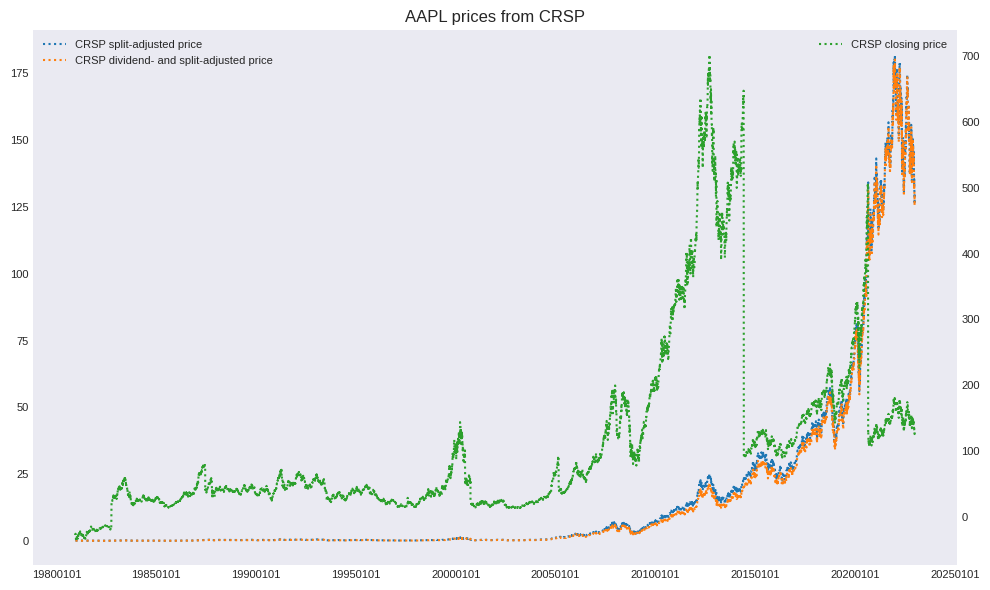

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_date(df[['price', 'adjPrice']], df['prc'],
          legend1=['CRSP split-adjusted price',
                   'CRSP dividend- and split-adjusted price'],
          legend2=['CRSP closing price'], title=f"{ticker} prices from CRSP",
          ls=':', fontsize=8, rotation=0, cn=0, ax=ax)
plt.tight_layout()

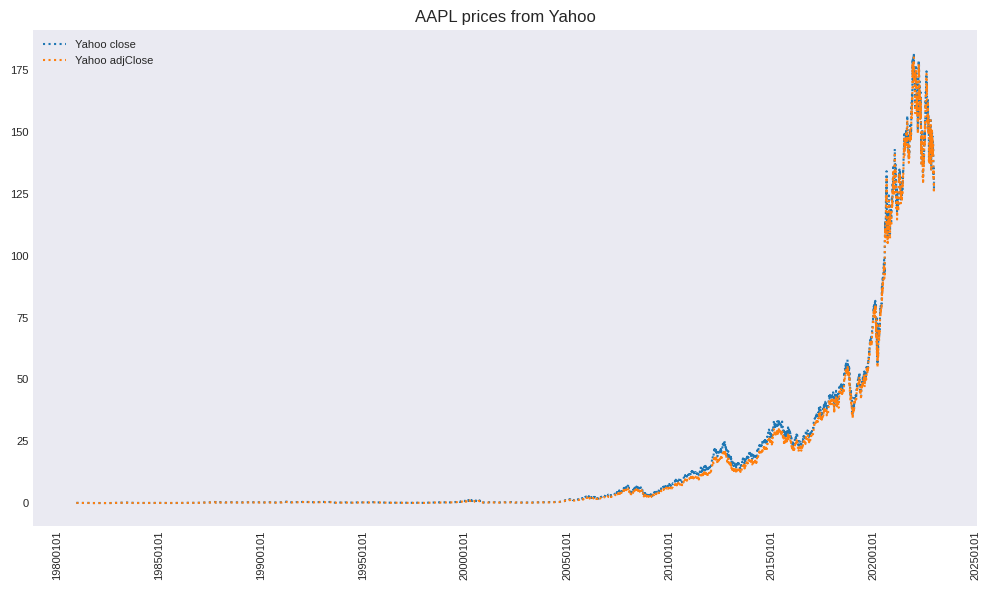

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_date(df[['close', 'adjClose']], legend1=['Yahoo close', 'Yahoo adjClose'],
          title=f"{ticker} prices from Yahoo",
          ls=':', fontsize=8, rotation=90, cn=0, ax=ax)
plt.tight_layout()

In [24]:
rets = DataFrame(data={
    'CRSP returns': [(df['retx'].iloc[1:] + 1).prod(),
                     (df['ret'].iloc[1:] + 1).prod()],
    'CRSP prices': [df['price'].iloc[-1] / df['price'].iloc[0],
                    df['adjPrice'].iloc[-1] / df['adjPrice'].iloc[0]],
    'Yahoo prices': [df['close'].iloc[-1] / df['close'].iloc[0],
                     df['adjClose'].iloc[-1] / df['adjClose'].iloc[0]],
    }, index=['Total Price Appreciation', 'Total Holding Returns'])
show(rets, caption=f"{ticker} stock returns with and without dividends:")

,CRSP returns,CRSP prices,Yahoo prices
AAPL stock returns with and without dividends:,,,
Total Price Appreciation,1065.5725,1065.6044,1068.0465
Total Holding Returns,1369.8131,1368.1319,1372.5507


__References:__

- Bali, Turan G, Robert F Engle, and Scott Murray. 2016. Empirical asset pricing: The cross section of stock returns. John Wiley & Sons.

- Fama, Eugene F., and Kenneth R. French. 1992. “The cross-section of expected stock returns.” The Journal of Finance 47 (2): 427–65.

- Shumway, Tyler. 1997. The Delisting Bias in CRSP Data. The Journal of Finance, 52, 327-340. 